In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from torch.linalg import norm
from sklearn.linear_model import LinearRegression
from dataset import AdSBHDataset
from model import AdSBHNet
from constants import dreal, dcomplex

ImportError: cannot import name 'real' from 'scipy' (/Users/helitakko/Dropbox/Own/deep-learning-EE/env-mac/complex_wilson/.venv/lib/python3.11/site-packages/scipy/__init__.py)

# Import dataset

In [2]:
dataset = AdSBHDataset(file='1607latticeT271.txt') # originally the data file here was lattice.txt
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

NameError: name 'AdSBHDataset' is not defined

Right now we can't solve for the `curve` for that high $T L$ so we'll drop some data points.

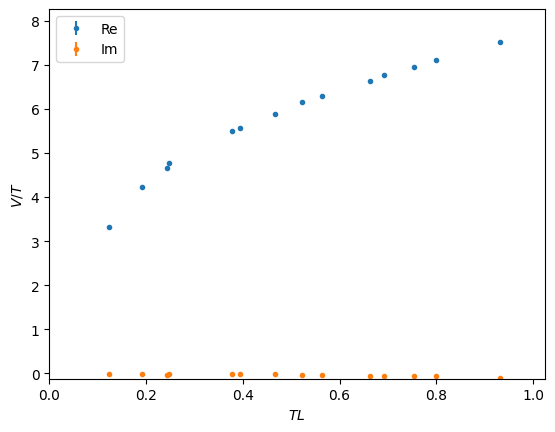

In [3]:
dataset.V = dataset.V[dataset.L < 1]
dataset.sigma = dataset.sigma[dataset.L < 1]
dataset.L = dataset.L[dataset.L < 1]
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='Re', fmt='.')
plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

# Initialize model

Parameter containing:
tensor([-0.1318, -0.6795, -0.2645, -0.0655], dtype=torch.float64,
       requires_grad=True) Parameter containing:
tensor([ 0.6708, -1.1637, -0.5654,  1.9063], dtype=torch.float64,
       requires_grad=True)
tensor(0.1426, grad_fn=<AddBackward0>) tensor(0.1449, grad_fn=<SubBackward0>) tensor(1.1213, grad_fn=<DivBackward0>)


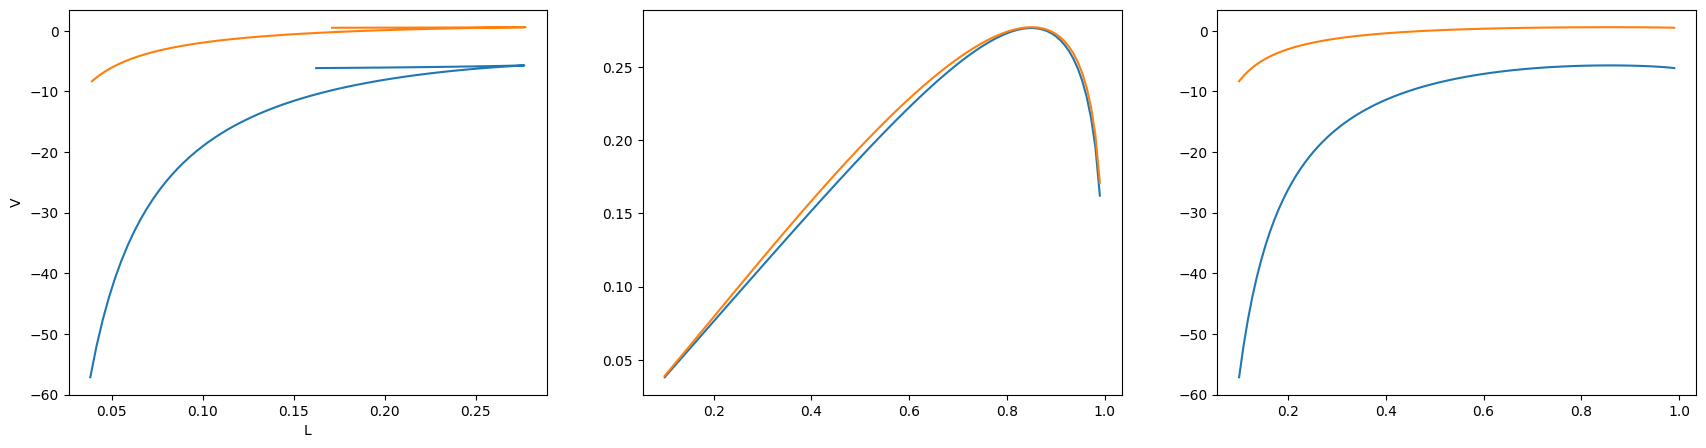

In [4]:
model = AdSBHNet(N=4, std=0.7)
#print(model.integrate_V(0.5))
#print(dataset.integrate_V(0.5))
print(model.a,model.b)
print(model.eval_a(0.9),model.eval_b(0.9),model.eval_g(0.4))
zs = np.linspace(0.1, 0.99, 100)
d_L = np.array([dataset.integrate_L(z).real for z in zs])
d_V = np.array([dataset.integrate_V(z).real for z in zs])
m_L = np.array([model.integrate_L(z).real.item() for z in zs])
m_V = np.array([model.integrate_V(z).real.item() for z in zs])
fig, axs = plt.subplots(1, 3, figsize=(21, 5))
axs[0].plot(d_L, d_V)
axs[0].plot(m_L, m_V)
axs[0].set_xlabel('L')
axs[0].set_ylabel('V')
axs[1].plot(zs, d_L)
axs[1].plot(zs, m_L)
axs[2].plot(zs, d_V)
axs[2].plot(zs, m_V)


It is advisable to try choosing reasonable initial values for `logcoef` and `shift` to help learning.

In [5]:
print(model.logcoef.exp())

tensor(0.2629, dtype=torch.float64, grad_fn=<ExpBackward0>)


In [6]:
print(model.logcoef)
with torch.no_grad():
    # Note that V_pred is proportional to `coef`.
    #coefnow = nn.Parameter(torch.tensor(0.15089977670036966,dtype=dreal).log())
    #model.logcoef = coefnow
    x = model(dataset.L).real.reshape(-1, 1) /model.logcoef.exp()
    x = x.numpy()
    y = dataset.V.real.numpy()
    fit = LinearRegression().fit(x, y)
    print(fit)
    # Set `logcoef` and `shift` to the linear fit values
    # previously model.logcoef = nn.Parameter(torch.tensor(fit.coef_, dtype=dreal).log())
    #model.logcoef = nn.Parameter(torch.tensor(fit.coef_, dtype=dreal).log())
    model.shift = nn.Parameter(torch.tensor(fit.intercept_, dtype=dreal))
plt.plot(dataset.L, y, '.', label='data')
#plt.plot(dataset.L, model.logcoef * x + fit.intercept_, '.', label='init')
plt.plot(dataset.L, fit.coef_ * x + fit.intercept_, '.', label='init')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.1*dataset.L.max())
plt.ylim(1.1*dataset.V.imag.min().item(), 1.1*dataset.V.real.max().item())
plt.legend();

Parameter containing:
tensor(-1.3360, dtype=torch.float64, requires_grad=True)


ERROR:root:Something wrong in Newton:
	zs = [(0.9442328171827359+0.6593371420721758j), (0.9370261520055742+0.6629530402796068j), (0.9336054388252439+0.7016278829617582j), (0.6080950428254722+0.9528453540465527j), (0.019365284635569857+1.401829118558629j), (0.056990139707853424+1.3165570690207296j), (0.1170103015188306+1.1986861076821405j), (0.11947090881961027+0.9836485534202993j), (0.26228526897845994+0.7703205163218492j), (0.8820158760903445+0.6608399417207466j), (0.8151784523393651+0.6814292728836893j), (0.6815921196034088+0.4021331727494849j), (1.4646632002047446+0.42592432429439536j), (2.225270942723531-0.07711124678669129j), (2.041102687150354-3.569051742438079j), (-2.232106092022392e+47+4.208752574504163e+46j)]
	L = 0.645840085803457
	_L = (4.26005249874264e-51+2.6726529780139693e-51j)
	dL = (-2.7940733518531804e-48-5.268371183159505e-49j)


AssertionError: integrate_L((-2.232106092022392e+47+4.208752574504163e+46j)) = (nan+nanj) for a = Parameter containing:
tensor([-0.1318, -0.6795, -0.2645, -0.0655], dtype=torch.float64,
       requires_grad=True) b = Parameter containing:
tensor([ 0.6708, -1.1637, -0.5654,  1.9063], dtype=torch.float64,
       requires_grad=True)

# Training

In [12]:
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=10)#previously 5
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) #previously 0.1
epochs = 100
a_vals, b_vals, coef_vals, shift_vals = [model.a.detach().numpy().copy()], [model.b.detach().numpy().copy()], [model.logcoef.exp().item()], [model.shift.item()]
eps=0.01 #previously this not here

z = np.linspace(0.001, 0.995, 50)
fzInit = model.eval_f(z).detach().numpy()
gzInit = model.eval_g(z).detach().numpy()
fz0 = 1-z**4
gz0 = 1/fz0

try:
    for epoch in range(epochs):
        for L, V, sigma in loader:
            optimizer.zero_grad()
            V_pred = model(L)
            V_diff = V_pred + model.shift - V
            loss = torch.mean(V_diff.real**2 / sigma.real) + torch.mean(V_diff.imag**2 / sigma.imag)
            loss.backward()
            a_vals.append(model.a.detach().numpy().copy())
            b_vals.append(model.b.detach().numpy().copy())
            coef_vals.append(model.logcoef.exp().item())
            shift_vals.append(model.shift.item())
            optimizer.step()
        print(f'epoch={epoch:2d}, loss={loss.item():0.6f}')
except KeyboardInterrupt:
    print('Stopping.')

fz = model.eval_f(z).detach().numpy()
gz = model.eval_g(z).detach().numpy()

AssertionError: integrate_L((2.9179707471854113+0.1770225465242531j)) = (nan+nanj) for a = Parameter containing:
tensor([ 2.0841,  1.4215, -1.2076, -3.6499], dtype=torch.float64,
       requires_grad=True) b = Parameter containing:
tensor([-0.4804,  0.7824,  0.9826,  2.3248], dtype=torch.float64,
       requires_grad=True)

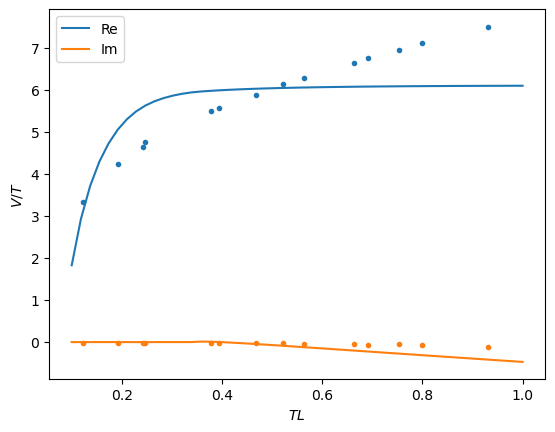

In [8]:
with torch.no_grad():
    L_grid = torch.linspace(0.1, 1.0, 50)
    V_grid = model(L_grid) + model.shift
plt.plot(L_grid, V_grid.real, label='Re')
plt.plot(L_grid, V_grid.imag, label='Im')
plt.errorbar(dataset.L, dataset.V.real, yerr=dataset.sigma.real, fmt='.', c='C0')
plt.errorbar(dataset.L, dataset.V.imag, yerr=dataset.sigma.imag, fmt='.', c='C1')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.legend();

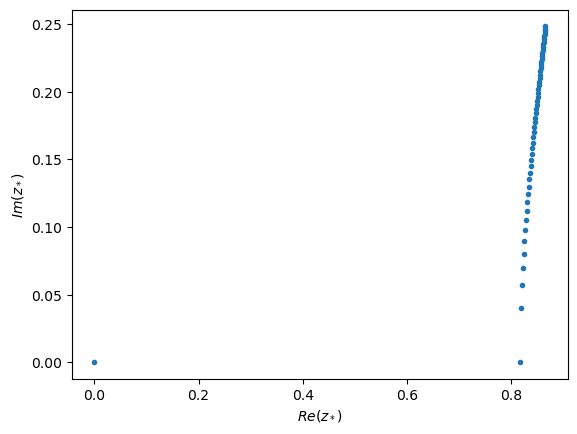

In [ ]:
plt.plot([np.real(x) for x in model.curve_zs], [np.imag(x) for x in model.curve_zs], '.')
plt.xlabel(f'$Re(z_*)$')
plt.ylabel(f'$Im(z_*)$');

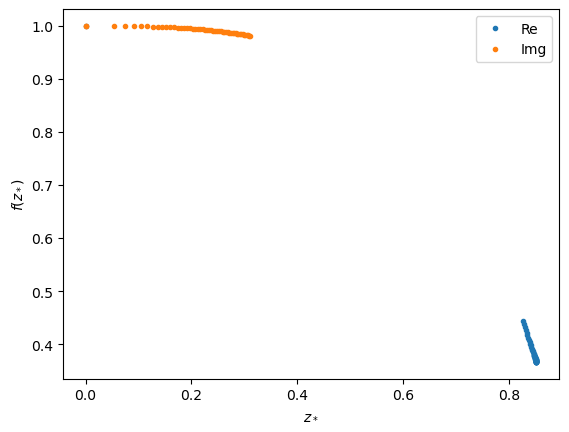

In [ ]:
plt.plot([np.real(x) for x in model.curve_zs], [float(model.eval_f(np.real(x)).detach().numpy()) for x in model.curve_zs], '.',label='Re')
plt.plot([np.imag(x) for x in model.curve_zs], [float(model.eval_f(np.imag(x)).detach().numpy()) for x in model.curve_zs], '.',label='Img')
plt.xlabel(f'$z_*$')
plt.ylabel(f'$f(z_*)$')
plt.legend()

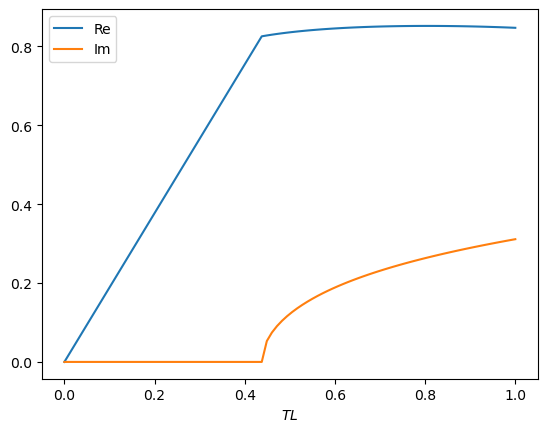

In [ ]:
plt.plot(model.curve_L, [np.real(x) for x in model.curve_zs], label='Re')
plt.plot(model.curve_L, [np.imag(x) for x in model.curve_zs], label='Im')
plt.xlabel(f'$T L$')
plt.legend();

[ 1.59472534  1.48248809  0.02780885 -0.65076932]
[-0.27224417  0.59099421  0.28295625  1.17047625]
0.5187400165913908
10.944854400415489
78.990207262243


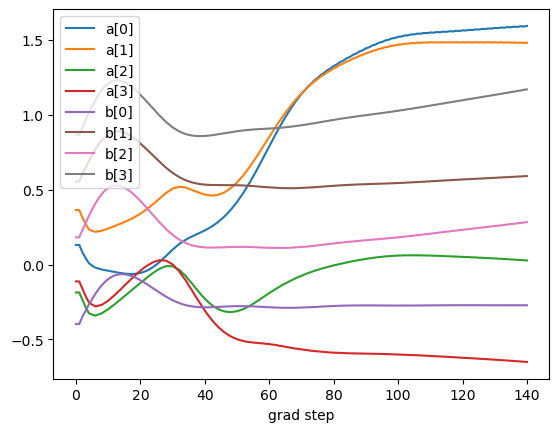

In [9]:
for i in range(len(a_vals[0])):
    plt.plot([a[i] for a in a_vals], label=f'a[{i}]')
for i in range(len(a_vals[0])):
    plt.plot([b[i] for b in b_vals], label=f'b[{i}]')
plt.xlabel('grad step')
plt.legend();
print(a_vals[-1])
print(b_vals[-1])
print(coef_vals[-1])
print(shift_vals[-1])
print(loss.item())

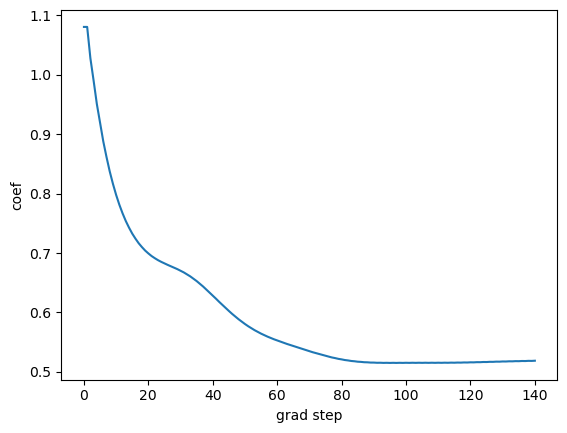

In [10]:
plt.plot(coef_vals, label='coef')
plt.xlabel('grad step')
plt.ylabel('coef');

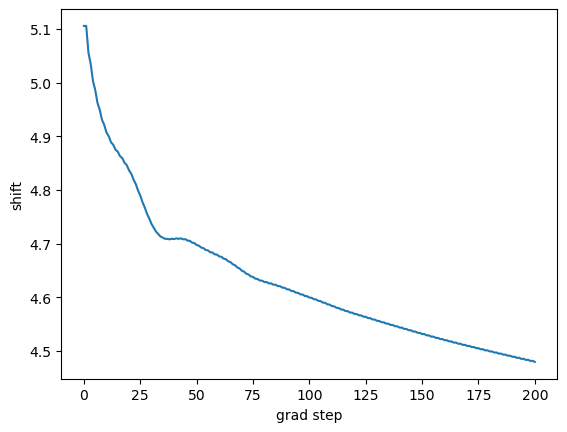

In [10]:
plt.plot(shift_vals, label='shift')
plt.xlabel('grad step')
plt.ylabel('shift');

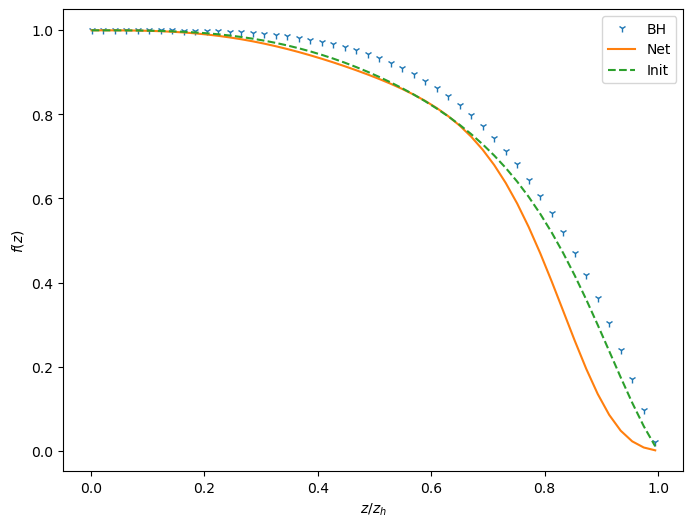

In [15]:
plt.subplots(figsize=(8, 6))
plt.plot(z, fz0, '1', label='BH')
plt.plot(z, fz, label='Net')
plt.plot(z, fzInit, '--', label='Init')
plt.xlabel(f'$z/z_h$')
plt.ylabel(f'$f(z)$')
plt.legend();

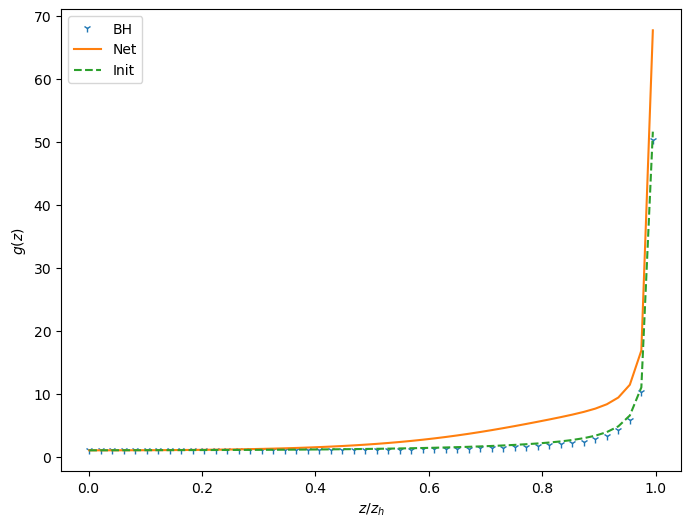

In [15]:
plt.subplots(figsize=(8, 6))
plt.plot(z, gz0, '1', label='BH')
plt.plot(z, gz, label='Net')
plt.plot(z, gzInit, '--', label='Init')
plt.xlabel(f'$z/z_h$')
plt.ylabel(f'$g(z)$')
plt.legend();

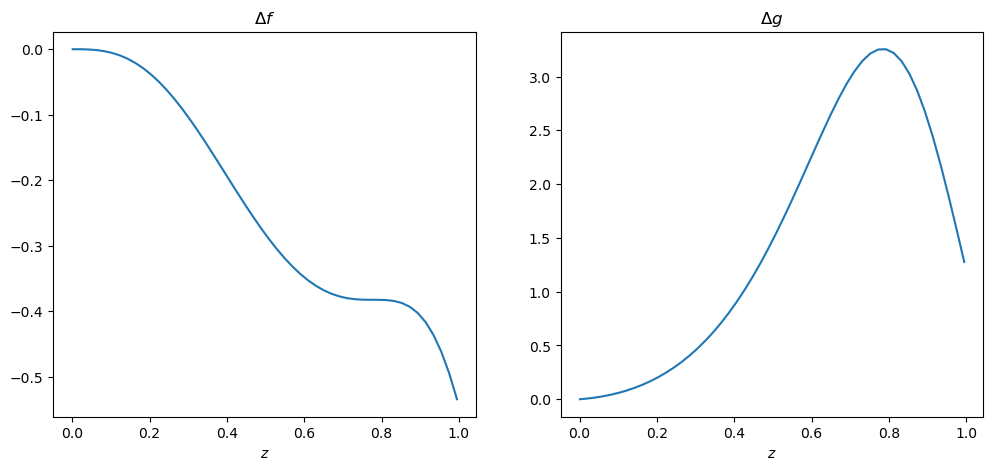

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(z, (fz-fz0)/fz0)
axs[0].set_title(f'$\Delta f$')
axs[0].set_xlabel(f'$z$')
axs[1].plot(z, (gz-gz0)/gz0)
axs[1].set_title(f'$\Delta g$')
axs[1].set_xlabel(f'$z$');

Text(0.5, 0, 'L')

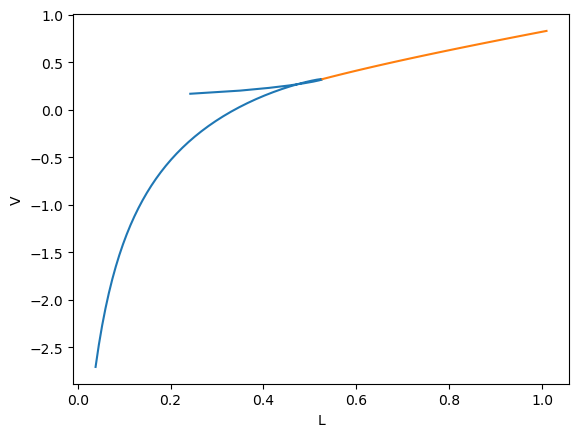

In [25]:
#for i in range(1,len(model.curve_zs)):
#    print(model.integrate_L(model.curve_zs[i]).detach().numpy(),model.integrate_V(model.curve_zs[i]).detach().numpy())
#dataset.integrate_V(z)
plt.plot([np.real(model.integrate_L(zs).detach().numpy()) for zs in np.linspace(0.1,0.99,50)],[np.real(model.integrate_V(zs).detach().numpy()) for zs in np.linspace(0.2,0.99,50)])
plt.plot([np.real(model.integrate_L(model.curve_zs[i]).detach().numpy()) for i in range(1,len(model.curve_zs))],[np.real(model.integrate_V(model.curve_zs[i]).detach().numpy()) for i in range(1,len(model.curve_zs))])
plt.ylabel('V')
plt.xlabel('L')

4.273043887080308
[ 1.82032867 -0.2779275  -1.94103511 -5.51655823] [0.28874471 2.24913519 5.09573168 4.39435988]
0.2091199030127042


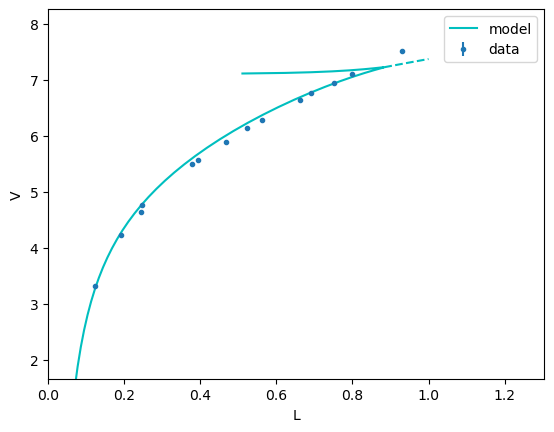

In [16]:
print(shift_vals[-1])
dataset.V = dataset.V[dataset.L < 1]
dataset.sigma = dataset.sigma[dataset.L < 1]
dataset.L = dataset.L[dataset.L < 1]
plt.errorbar(dataset.L.numpy(), dataset.V.real.numpy(), yerr=dataset.sigma.real.numpy(), label='data', fmt='.')
#plt.errorbar(dataset.L.numpy(), dataset.V.imag.numpy(), yerr=dataset.sigma.imag.numpy(), label='Im', fmt='.')
plt.xlabel(f'$T L$')
plt.ylabel(f'$V/T$')
plt.xlim(0, 1.4*dataset.L.max())
plt.ylim(0.5*dataset.V.real.min().item(), 1.1*dataset.V.real.max().item())
zs = np.linspace(0.25, 0.99, 50)
#d_L = np.array([dataset.integrate_L(z).real for z in zs])
#d_V = np.array([dataset.integrate_V(z).real for z in zs])
plt.plot([np.real(model.integrate_L(zs).detach().numpy()) for zs in np.linspace(0.1,0.99,50)],[shift_vals[-1]+np.real(model.integrate_V(zs).detach().numpy()) for zs in np.linspace(0.1,0.99,50)],'c-',label='model')
plt.plot([np.real(model.integrate_L(model.curve_zs[i]).detach().numpy()) for i in range(1,len(model.curve_zs))],[shift_vals[-1]+np.real(model.integrate_V(model.curve_zs[i]).detach().numpy()) for i in range(1,len(model.curve_zs))],'c--')
plt.ylabel('V')
plt.xlabel('L')
#plt.plot(d_L,d_V)
#plt.plot([np.real(dataset.integrate_L(model.curve_zs[i])) for i in range(1,len(model.curve_zs))],[np.real(dataset.integrate_V(model.curve_zs[i])) for i in range(1,len(model.curve_zs))])
plt.ylabel('V')
plt.xlabel('L')
plt.legend();
print(a_vals[-1],b_vals[-1])
print(coef_vals[-1])

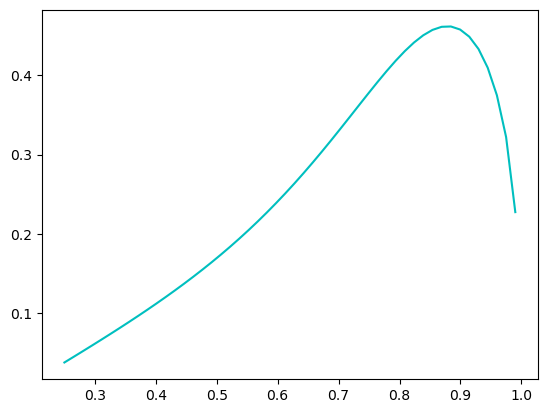

In [18]:
zs = np.linspace(0.25, 0.99, 50)
#d_L = np.array([dataset.integrate_L(z).real for z in zs])
#d_V = np.array([dataset.integrate_V(z).real for z in zs])
plt.plot(zs,[np.real(model.integrate_L(zs).detach().numpy()) for zs in np.linspace(0.1,0.99,50)],'c-',label='model')

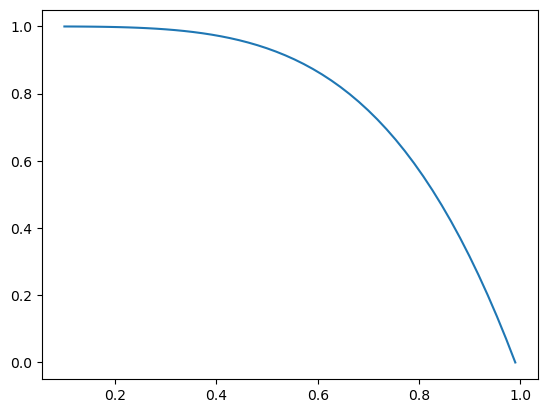

In [ ]:
plt.plot([zs for zs in np.linspace(0.1,0.99,50)],[np.real(model.eval_f(zs).detach().numpy()) for zs in np.linspace(0.1,1,50)])

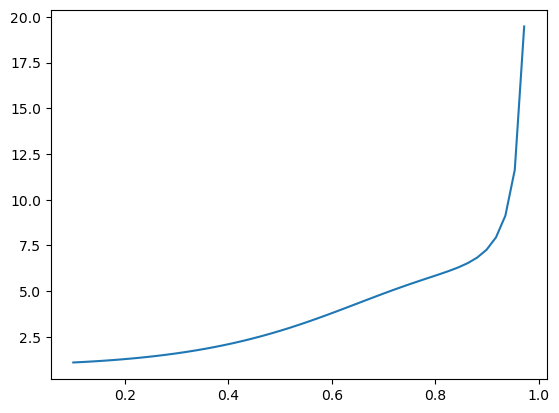

In [ ]:
plt.plot([zs for zs in np.linspace(0.1,0.99,50)],[np.real(model.eval_g(zs).detach().numpy()) for zs in np.linspace(0.1,1,50)])

Export the data for each temperature as structure with following columns
[1] = z_*
[2] = f(z_*)
[3] = g(z_*)
[4] = l(z_*)
[5] = V(z_*)
We do this separately for real and imaginary cases of z_*

In [29]:
# for real z_*
for zs in np.linspace(0.01,0.99,100):
    print('{',zs,',',model.eval_f(zs).detach().numpy(),',',model.eval_g(zs).detach().numpy(),',',np.real(model.integrate_L(zs).detach().numpy()),',',np.real(model.integrate_V(zs).detach().numpy())[0],'},')

{ 0.01 , 0.9999984834046913 , 1.0001597425660675 , 0.003814024964185944 , -59.06373752419402 },
{ 0.0198989898989899 , 0.9999880338740377 , 1.0005807008101686 , 0.007590663114771748 , -29.100808738540948 },
{ 0.029797979797979796 , 0.9999597680761917 , 1.0012869947214134 , 0.011369513357756003 , -19.37280308886287 },
{ 0.039696969696969696 , 0.9999047668248014 , 1.0023036607665503 , 0.015151717584853152 , -14.518507157148239 },
{ 0.049595959595959596 , 0.9998140852346946 , 1.0036569849738695 , 0.018938489542845438 , -11.603346659091496 },
{ 0.059494949494949496 , 0.9996787641743372 , 1.0053744896781742 , 0.022731120131870997 , -9.656691273557037 },
{ 0.06939393939393938 , 0.999489842984679 , 1.0074849312367802 , 0.02653098239227908 , -8.263369250322793 },
{ 0.07929292929292929 , 0.9992383734265899 , 1.0100183090857824 , 0.03033953621311064 , -7.215889597241065 },
{ 0.08919191919191918 , 0.9989154348095668 , 1.0130058864691875 , 0.034158332794340135 , -6.398976548530476 },
{ 0.099090909

In [30]:
# for imaginary z_*
for zs in model.curve_zs[1:]:
    print('{',zs,',',np.real(model.eval_f(zs).detach().numpy()),',',np.real(model.eval_g(zs).detach().numpy()),',',np.real(model.integrate_L(zs).detach().numpy()),',',np.real(model.integrate_V(zs).detach().numpy())[0],'},')

{ (0.851421211220324+0j) , 0.3840515 , 8.57237 , 0.5271845104339283 , 0.32204790670048555 },
{ (0.8533638131776088+0.034942416706021814j) , 0.38445312 , 8.619831 , 0.5366408202448532 , 0.33396116247333785 },
{ (0.8552481645293581+0.04916523306340127j) , 0.38494748 , 8.674983 , 0.5460971300166613 , 0.34572951313822387 },
{ (0.8570765169045672+0.059913855658290195j) , 0.38553116 , 8.737351 , 0.5555534406680855 , 0.3573600007776634 },
{ (0.8588510247245511+0.06884175795075675j) , 0.386201 , 8.806464 , 0.5650097496725508 , 0.3688592213130173 },
{ (0.8605737371396672+0.07659362298423344j) , 0.3869535 , 8.881923 , 0.5744660594030898 , 0.3802333738112891 },
{ (0.8622466176952487+0.08350218816353322j) , 0.38778508 , 8.963355 , 0.5839223691850771 , 0.3914882775044828 },
{ (0.8638715421736469+0.08976634902157148j) , 0.38869312 , 9.050407 , 0.5933786789743185 , 0.4026294064554463 },
{ (0.8654503040068284+0.09551648787435749j) , 0.38967404 , 9.142778 , 0.602834988765011 , 0.41366191418822873 },
{ 

TO DO:

- pieni lämpötila: muuttaa reunaehtoja sikarigeometrian mukaisesti?
- WL jälkeen muut kysymykse: BH horizon area? -> QFT entropy saadusta metriikasta
- entropian jälkeen null-energy conditions (NEC): meillä on Einsteinin yhtälö, 
- entropian laskemisen jälkeen pitäisi löytää entropian dataa jostain johon verrata
- energia-momenttitensori --> äänen nopeus (tensorin komponentit kts. 1707.80521.pdf)